# Analyze One Trained Model

In [13]:
import pandas as pd
import os.path
import os
import h5py
import numpy as np
import tqdm
from tqdm import tqdm_notebook
import itertools
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

import seaborn as sb

In [17]:
run = "test0"
model_dir = os.getcwd()+'/'+f"models/{run}/"
fig_dir = model_dir+"figs/"

In [8]:
# Read data from local
with h5py.File(os.getcwd()+'/data/'+"X.h5","r") as f:
    lcs = np.array(f["X"])
    times = np.array(f["time"])

with h5py.File(os.getcwd()+'/data/'+"Y.h5","r") as f:
    pars = np.array(f["Y"])
    features_names = list([str(val.decode("utf-8")) for val in f["keys"]])

print(f"lcs={lcs.shape}, pars={pars.shape}, times={times.shape}")
print(f"lcs={lcs.min()}, {lcs.max()}, pars={pars.min()} {pars.max()}, times={times.shape}")
print(features_names)

lcs=(43200, 150), pars=(43200, 7), times=(150,)
lcs=4.1156688517299256e-13, 101.53666687011719, pars=0.0 92999999488.0, times=(150,)
['eps_e', 'eps_b', 'eps_t', 'p', 'theta_obs', 'n_ism', 'freq']


In [9]:
# load model
import torch
from model_cvae import CVAE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    torch.cuda.empty_cache()
    
def load_model(model_file):
    model = CVAE(image_size=len(lcs[0]),  #  150
                 hidden_dim=700,
                 z_dim=4 * len(features_names),
                 c=len(features_names))
    model.to(device)
    model.load_state_dict(torch.load(model_file))
    model.eval()
    return model
    
fname = os.getcwd()+'/'+"models/"+"VAE_model_loglr3_batch64.pt"

model = load_model(fname)
df_train = pd.read_csv(fname.replace(".pt","_train_losses.csv"))
df_test = pd.read_csv(fname.replace(".pt","_test_losses.csv"))

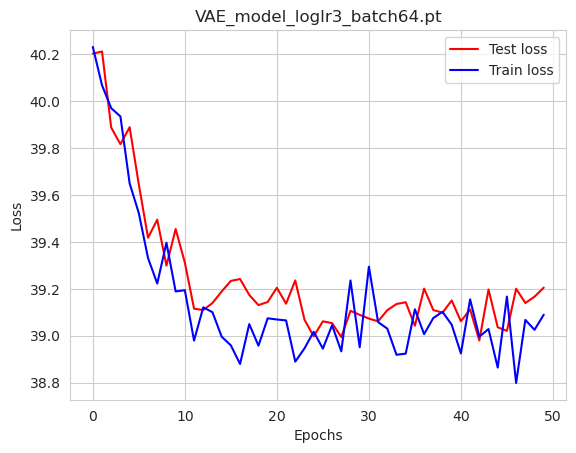

In [10]:
# Plot train/test loss function as a function of time
fig, ax = plt.subplots(ncols=1,nrows=1)
ax.plot(range(df_test.shape[0]),df_test['Loss'],color="red",label="Test loss")
ax.plot(range(df_train.shape[0]),df_train['Loss'],color="blue",label="Train loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title(fname.split('/')[-1])
ax.legend(loc="best")

In [11]:
# inference
from train import LightCurveDataset
dataset = LightCurveDataset(pars, lcs, times)

def inference(pars:list, model:CVAE, dataset:LightCurveDataset, device):
    # if len(pars) != model.z_dim:
    #     raise ValueError(f"Number of parameters = {len(pars)} does not match the model latent space size {model.z_dim}")
    # create state vector for intput data (repeat physical parameters for times needed)
    pars = np.asarray(pars).reshape(1, -1)
    # normalize parameters as in the training data
    normed_pars = dataset._transform_pars(_pars=pars)
    # generate prediction
    with torch.no_grad():
        # convert intput data to the format of the hidden space
        z = (torch.zeros((1, model.z_dim)).repeat((len(normed_pars), 1)).to(device).to(torch.float))
        # create the input for the decoder 
        decoder_input = torch.cat((z, torch.from_numpy(normed_pars).to(device).to(torch.float)), dim=1)
        # perform reconstruction using model
        reconstructions = model.decoder(decoder_input)
    # move prediction to cpu and numpy
    reconstructions_np = reconstructions.double().cpu().detach().numpy()
    # undo normalization that was done in training data
    lc_nn = dataset.inverse_transform_lc_log(reconstructions_np)
    return lc_nn
# 'eps_e', 'eps_b', 'eps_t', 'p', 'theta_obs', 'n_ism', 'freq'
#new_pars = [.1, 0.01, 1., 2.2, 0., 0.01, 2.4e9]
#lc = inference(new_pars, model, dataset, device)

(43200, 7) (7,)
(1, 7) (43200,)


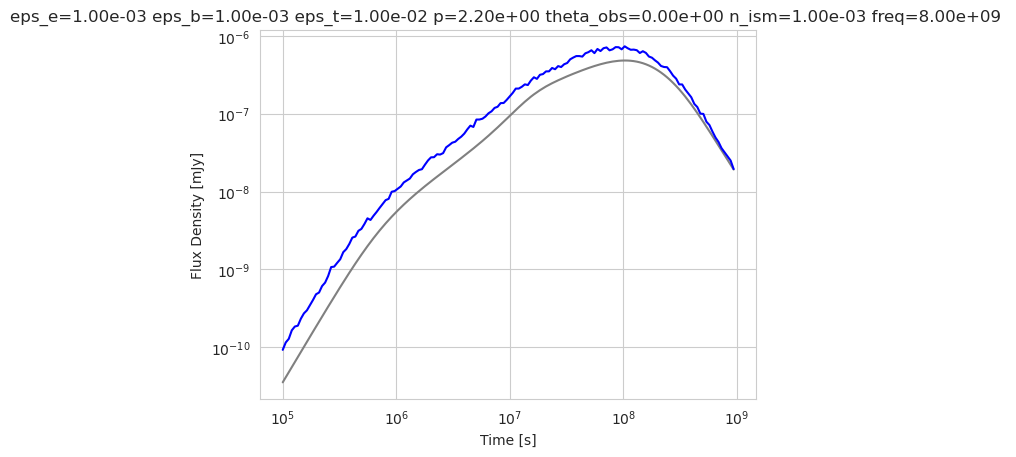

(43200, 7) (7,)
(1, 7) (43200,)


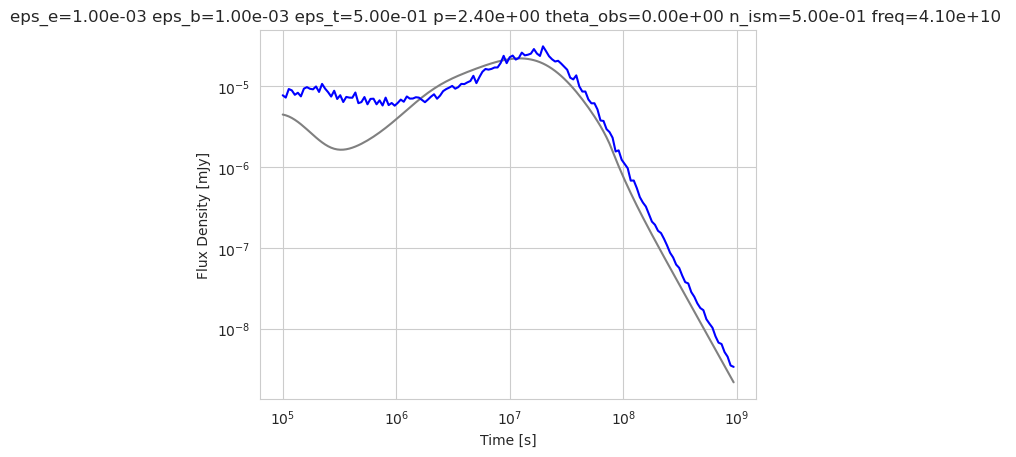

(43200, 7) (7,)
(1, 7) (43200,)


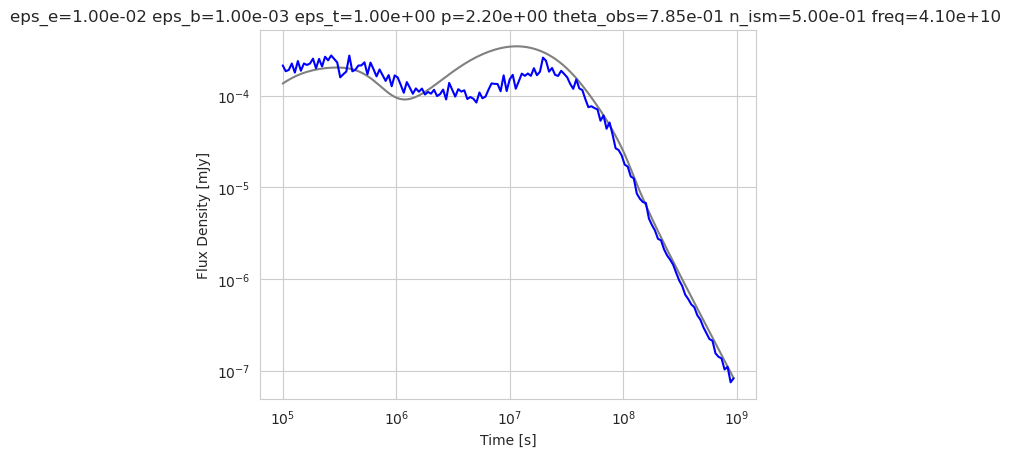

In [12]:
def plot_one(i = 0):

    lc = lcs[i]
    par = pars[i]
    print(pars.shape, par.shape)
    title = "".join([_par+"="+f"{_val:.2e} " for _par,_val in zip(features_names,par)])
    plt.loglog(times, lc, color='gray')

    lc_nn = inference(par, model, dataset, device)
    lc_nn = lc_nn[0]
    plt.ylabel("Flux Density [mJy]")
    plt.xlabel("Time [s]")
    plt.loglog(times, lc_nn, color='blue')
    plt.title(title)
    plt.show()

plot_one(1)
plot_one(1000)
plot_one(10000)

# Visualize Latent Space

In [22]:
# Plot 3 columns for Xhat, Mu, LogVar for all features (2D using t-SNE)
def plot_latent_space_for_epoch(xhat_,mu_,logvar_,phys_,figname):
    # unpack
    x_xhat, y_yhat = xhat_[:, 0], xhat_[:, 1]
    x_mu, y_mu = mu_[:, 0], mu_[:, 1]
    x_logvar, y_logvar = logvar_[:, 0], logvar_[:, 1]
    
    # plot
    cmap_name = "coolwarm_r" # 'coolwarm_r'
    fig, axes = plt.subplots(ncols=3,nrows=len(features_names),figsize=(8,12))
    
    axes[0, 0].set_title("Xhat")
    axes[0, 1].set_title("mu")
    axes[0, 2].set_title("logvar")
    for i, f in enumerate(features_names):
        # print(np.min(phys_[:,i]),', ', np.max(phys_[:,i]))
        if (np.min(phys_[:,i])<=0
                or (np.max(phys_[:, i])/np.min(phys_[:, i])<10)):
            norm = Normalize(vmin=np.min(phys_[:, i]),
                             vmax=np.max(phys_[:, i]))
        else:
            norm = LogNorm(vmin=np.min(phys_[:,i]),
                           vmax=np.max(phys_[:,i]))
    
        cmap = plt.get_cmap(cmap_name)
    
        colors = cmap(norm(phys_[:,i]))
        # labels_collated[:,i]
    
        im = axes[i,0].scatter(x_xhat, y_yhat, marker='.', s=20, c=colors, alpha=.6)
        im = axes[i,1].scatter(x_mu, y_mu, marker='.', s=20, c=colors, alpha=.6)
        im = axes[i,2].scatter(x_logvar, y_logvar, marker='.', s=20, c=colors, alpha=.6)
    
        divider = make_axes_locatable(axes[i,2])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap),
                            cax=cax, orientation='vertical', label=features_names[i])
    
        for ax in axes[i,:]:
            # Hide X and Y axes label marks
            ax.xaxis.set_tick_params(labelbottom=False)
            ax.yaxis.set_tick_params(labelleft=False)
    
            # Hide X and Y axes tick marks
            ax.set_xticks([])
            ax.set_yticks([])
    
            ax.patch.set_visible(False)
            ax.axis('off')
    
    # plt.scatter(x, y, marker='.', s=20, c=labels_collated[:,5], cmap='coolwarm_r', alpha=.7)
    # plt.colorbar(label=features_names[5])
    
    # plt.xlabel('embedding 1')
    # plt.ylabel('embedding 2')
    # plt.legend(loc='best', fontsize='x-large')
    plt.tight_layout()
    plt.savefig(figname,dpi=256)
    print(f"\tsaving...{figname}")
    plt.close(fig)
    # plt.show()
    
    # 
    # 
    # 
    # mode='imgs'
    # fig, ax = plt.subplots(figsize=(10, 7))
    # ax.set_title(f't-SNE for {epoch}')
    # if mode == 'imgs':
    #     for image, (x, y) in zip(data_collated.cpu(), xhat_tsne):
    #         im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
    #         ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
    #         ax.add_artist(ab)
    #     ax.update_datalim(xhat_tsne)
    #     ax.autoscale()
    # elif mode == 'dots':
    #     classes = labels_collated
    #     plt.scatter(xhat_tsne[:, 0], xhat_tsne[:, 1])
    #     # plt.colorbar()
    #     # for i in range(10):
    #     #     class_center = np.mean(coords[classes == i], axis=0)
    #     #     text = TextArea('{}'.format(i))
    #     #     ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
    #     #     ax.add_artist(ab)
    # # plt.show()
    # plt.savefig(figdir+f"latent_{epoch}.png")

In [23]:
# load latent sapce
dimensity_reduction_method = "t-SNE"
# init file where to store reduced latent sapce
run_name="test0"
outdir = os.getcwd()+"/models/"+run_name+"/"
fname = outdir+f"latent_{dimensity_reduction_method}.h5"
if not os.path.isfile(fname):
    print(f"File not found: {fname}")
    raise FileNotFoundError(f"File not found: {fname}")

with h5py.File(fname,"r") as f:
    epochs = int(f.attrs["epochs"])
    features_names = list([str(val.decode("utf-8")) for val in f["features_names"]])
    
    for e in range(epochs):
        group = f[f"epoch={e}"]
        plot_latent_space_for_epoch(
            xhat_ =np.array(group["xhat"]),
            mu_ =np.array(group["mu"]),
            logvar_ =np.array(group["logvar"]),
            phys_ =np.array(group["phys_labels"]),
            figname =fig_dir+"latent_"+str(e).zfill(3)+".png"
        )
print("Latent space for all epochs plotted")
        

	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_000.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_001.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_002.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_003.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_004.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_005.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_006.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_007.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/latent_008.png
	saving.../home/vsevolod/Work/GIT/GitHub/PBA_projects/ml_lightcurve/models/test0/figs/laten

In [ ]:
def get_latent_data(net, count=1000, is_cvae=False):
    latent_vectors = []
    latent_labels = []
    img_inputs = []
    rounds = count/100
    i=0
    with torch.set_grad_enabled(False):
        dataset_loader = DataLoader(dataset, batch_size=100, shuffle=True)
        for inputs,labels in dataset_loader:
            inputs = inputs.to(DEVICE)
            labels_one_hot = one_hot(labels,9).to(DEVICE)
            if is_cvae:
                outputs, mu, logvar = net(inputs,labels_one_hot)
            else:
                outputs = net(inputs,labels_one_hot)
            outputs = outputs.cpu()
            if i==0:
                latent_vectors = outputs
                latent_labels = labels
                img_inputs = inputs
            else:
                latent_vectors = torch.cat((latent_vectors,outputs),0)
                latent_labels = torch.cat((latent_labels,labels),0)
                img_inputs = torch.cat((img_inputs,inputs),0)
            if i>rounds:
                break
            i+=1
    return img_inputs, latent_vectors, latent_labels

def plot_tsne(net, mode, count, is_cvae=False):
    
    img_inputs,latent_vectors,latent_labels = get_latent_data(net=net, count=count, is_cvae=is_cvae)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title('t-SNE')
    coords = TSNE(n_components=2,random_state=42).fit_transform(latent_vectors)
    if mode == 'imgs':
        for image, (x, y) in zip(img_inputs.cpu(), coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = latent_labels
        plt.scatter(coords[:, 0], coords[:, 1], c=classes)
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{}'.format(i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

In [ ]:
def evaluate_encoder(model, dataloader, params,
                     n_classes=5, force=False, device='cpu'):
    """Creates a joint plot of features, used during training, figures
    are W&B ready

    Parameters
    ----------
    model      : pytorch obejct
        model to be evaluated
    dataloader : pytorch object
        dataloader object with data to be evaluated with model
    params     : dictionary
        dictionary of model configuration parameters
    n_classes  : int
        number of unique classes/labels availables in the data
    force      : bool, optional
        wheather to force model evaluation or load values from file archive
    device     : str, optional
        device where model runs, gpu or cpu

    Returns
    -------
    mu_df
        Pandas dataframe of mu values, last column are the labels 
    std_df
        Pandas dataframe of std values, last column are the labels 
    """

    fname_mu = '%s/wandb/run-%s-%s/latent_space_mu.txt' % (path,
                                                           params['date'], params['ID'])
    fname_std = '%s/wandb/run-%s-%s/latent_space_std.txt' % (path, params['date'], params['ID'])
    fname_lbs = '%s/wandb/run-%s-%s/labels.txt' % (path, params['date'], params['ID'])
    
    
    if os.path.exists(fname_mu) & os.path.exists(fname_std) & os.path.exists(fname_lbs) &  ~force:
        print('Loading from files...')
        mu = np.loadtxt(fname_mu)
        std = np.loadtxt(fname_std)
        labels = np.loadtxt(fname_lbs, dtype=np.str)

    else:
        print('Evaluating Encoder...')
        time_start = datetime.datetime.now()

        mu, logvar, xhat, labels = [], [], [], []
        with tqdm_notebook(total=len(dataloader)) as pbar:
            for i, (data, label, onehot, pp) in enumerate(dataloader):
                data = data.to(device)
                onehot = onehot.to(device)
                pp = pp.to(device)
                cc = torch.cat([onehot, pp], dim=1)
                if params['label_dim'] > 0 and params['physics_dim'] > 0:
                    mu_, logvar_ = model.encoder(data, label=onehot, phy=pp)
                elif params['label_dim'] > 0 and params['physics_dim'] == 0:
                    mu_, logvar_ = model.encoder(data, label=onehot)
                elif params['label_dim'] == 0:
                    mu_, logvar_ = model.encoder(data)
                else:
                    print('Check conditional dimension...')
                mu.extend(mu_.data.cpu().numpy())
                logvar.extend(logvar_.data.cpu().numpy())
                labels.extend(label)
                torch.cuda.empty_cache()
                pbar.update()
        mu = np.array(mu)
        std = np.exp(0.5 * np.array(logvar))

        #np.savetxt(fname_mu, mu)
        #np.savetxt(fname_std, std)
        #np.savetxt(fname_lbs, np.asarray(labels), fmt='%s')
        elap_time = datetime.datetime.now() - time_start
        print('Elapsed time  : %.2f s' % (elap_time.seconds))
        print('##'*20)

    mu_df = pd.DataFrame(mu)
    std_df = pd.DataFrame(std)

    mu_df['class'] = labels
    std_df['class'] = labels

    return mu_df, std_df

mu, std = evaluate_encoder(vae, dataloader, config,
                           n_classes=num_cls, force=False)

In [ ]:
g = sb.PairGrid(mu,
                hue='class', hue_order=sorted(set(mu.loc[:,'class'].values)),
                corner=False, despine=True, palette='Dark2_r')
g = g.map_diag(plt.hist, histtype='step', lw=1.5)
g = g.map_offdiag(plt.scatter, marker='.', s=20, alpha=.5, edgecolors='none')
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
g = g.add_legend(loc='upper center', fontsize=20, title='',
                 markerscale=4, ncol=2)
for ax in g.axes.flat:
    # This only works for the left ylabels
    ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
    ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')

plt.show()